In [12]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc
from numba import njit, prange
import matplotlib.pyplot as plt
from montecarlo.Energies.numba_energies import delta_energy
from tqdm import tqdm

In [2]:
region = df.Region(p1=(-50e-9, -50e-9, -10e-9), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(2.5e-9, 2.5e-9, 2.5e-9))
system = mm.System(name='skyrmion')

In [3]:

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='Cnv_z')
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 2e5)))
# system.energy = mm.DMI(D=4e-3, crystalclass='Cnv_z')

In [4]:
system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='Cnv_z') + UniaxialAnisotropy(K=510000.0, u=(0, 0, 1)) + Demag() + Zeeman(H=(0, 0, 200000.0))

In [5]:
Ms = 1.1e6

def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is 50nm.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 50e-9:
        return Ms
    else:
        return 0

def m_init(pos):
    """Function to set initial magnetisation direction:
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

/Users/gmn22/miniconda3/envs/irp/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/gmn22/miniconda3/envs/irp/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


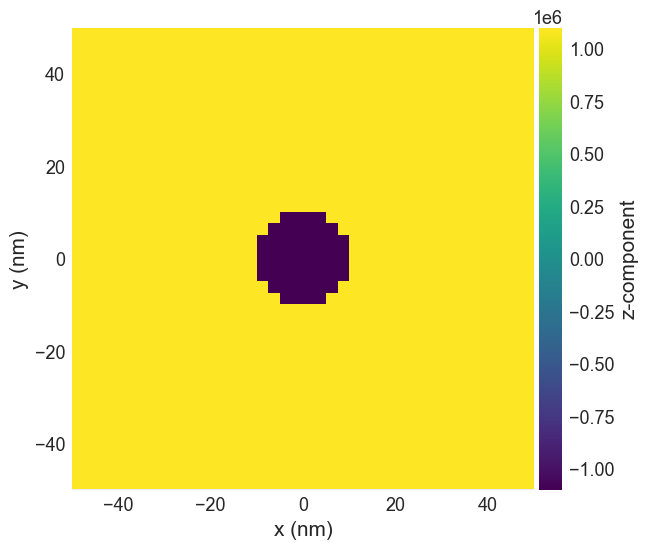

In [6]:
system.m.plane('z').mpl()

In [7]:
class MCDriver2():
    def __init__(self, system) -> None:
        self.m0 = 4*np.pi*1e-7 # Tm/A
        magnitudes = np.linalg.norm(system.m.array, axis=-1)
        magnitudes[magnitudes == 0] = 1 #avoid division by zero
        self.grid = system.m.array/magnitudes[..., np.newaxis] #normalise vectors to get m(r)
       
        self.dx, self.dy, self.dz = np.array(system.m.mesh.cell)
        self.temperature = system.T + 300.1 #avoid division by zero
        self.Kb = 1.38064852e-23 #Boltzmann constant
        # What about multiple similar energy terms????
        try:
            self.zeeman_K = np.array(system.energy.zeeman.H)
        except:
            self.zeeman_K = None
        try:
            self.exchange_A =  system.energy.exchange.A
        except:
            self.exchange_A = None
        try:
            self.dmi_D = system.energy.dmi.D
            self.type = system.energy.dmi.crystalclass
        except:
            self.dmi_D = None
        try:
            self.anisotropic_K, self.anisotropic_u = (system.energy.uniaxialanisotropy.K, np.array(system.energy.uniaxialanisotropy.u))
        except:
            self.anisotropic_K, self.anisotropic_u = (None, None)
        try:
            self.demag_N = system.energy.demag.N
        except:
            self.demag_N = None


In [8]:
@njit(fastmath=True)
def driver(N, grid, zeeman_K, anisotropic_K, anisotropic_u, exchange_A, dmi_D, m0, Ms, dx, dy, dz, Kb, temperature):
    spins = np.zeros((2, 3), dtype='float64')

    for _ in prange(N):
        # 1. Randomly select a cell
        cell_x = np.random.randint(0, grid.shape[0])
        cell_y = np.random.randint(0, grid.shape[1])
        cell_z = np.random.randint(0, grid.shape[2])

        # check if the cell is within 2 cells from the boundary
        if 2 <= cell_x <= grid.shape[0] - 3 and 2 <= cell_y <= grid.shape[1] - 3 and 2 <= cell_z <= grid.shape[2] - 3:
            small_grid = grid[cell_x-2:cell_x+3, cell_y-2:cell_y+3, cell_z-2:cell_z+3]
        else:
            
            small_grid = np.empty((5, 5, 5, 3))
    
            for i in prange(-2, 3):
                for j in prange(-2, 3):
                    for k in prange(-2, 3):
                        x, y, z = cell_x + i, cell_y + j, cell_z + k
                        value = ( grid[x, y, z] if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1] and 0 <= z < grid.shape[2]
                                else grid[min(max(x, 0), grid.shape[0]-1),
                                        min(max(y, 0), grid.shape[1]-1),
                                        min(max(z, 0), grid.shape[2]-1)]
                                )
                        small_grid[i + 2, j + 2, k + 2] = value
        
        # 3. energy before the change
        spins[0] = small_grid[2, 2, 2]

        # 4. randomly select a direction
        direction = small_grid[2, 2, 2] + np.random.uniform(-0.1, 0.1, size=3)
        #normalise the vector
        magnitude = np.sqrt(direction[0]**2 + direction[1]**2 + direction[2]**2)
        direction = direction/magnitude
        spins[1] = direction
        
        delta_E = delta_energy(small_grid, spins, m0, Ms, zeeman_K, exchange_A, anisotropic_K, anisotropic_u, dmi_D, dx, dy, dz)

        # 6. Decision
        if delta_E < 0: #if energy is lower than previous energy, accept the change
            grid[cell_x, cell_y, cell_z] = direction #accept the change
        else: #if energy is higher than previous energy, accept the change with probability exp(-dE/kT)
            if np.random.uniform(0, 1) < np.exp(-(delta_E)/(Kb*temperature)):
                grid[cell_x, cell_y, cell_z] = direction #accept the change
            else:
                #reject the change
                grid[cell_x, cell_y, cell_z] = spins[0] #revert the change 
                
    return grid

In [9]:
# How can I apply better approximation of central difference?
# compare the anisotrophic energy with other's implementation 
mc1 = MCDriver2(system)

In [10]:
new_dir = driver(100, mc1.grid, mc1.zeeman_K, mc1.anisotropic_K, mc1.anisotropic_u, mc1.exchange_A, mc1.dmi_D, mc1.m0, Ms, mc1.dx, mc1.dy, mc1.dz, mc1.Kb, mc1.temperature)

In [11]:
new_dir = driver(11000000, mc1.grid, mc1.zeeman_K, mc1.anisotropic_K, mc1.anisotropic_u, mc1.exchange_A, mc1.dmi_D, mc1.m0, Ms, mc1.dx, mc1.dy, mc1.dz, mc1.Kb, mc1.temperature)

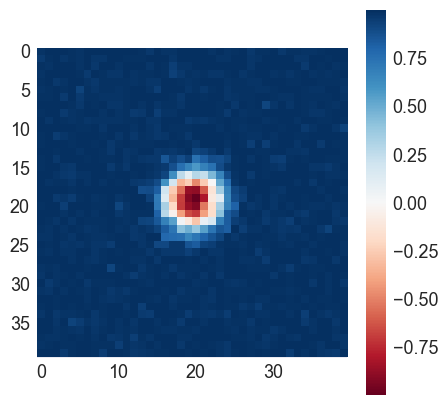

In [15]:
# plot the z component of the magnetic moment in the xy plane with the color map representing the z component of the magnetic moment in the z direction

plt.figure(figsize=(5,5))
plt.imshow(new_dir[:, :, 0, 2], cmap='RdBu')
plt.colorbar()




In [22]:
system.m.array = new_dir

In [91]:
import pickle

def state_save(state, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(state, f)

def state_load(file_name):
    with open(file_name, 'rb') as f:
        state = pickle.load(f)
    return state

def state_save_npz(state, file_name):
    np.save(file_name, state)


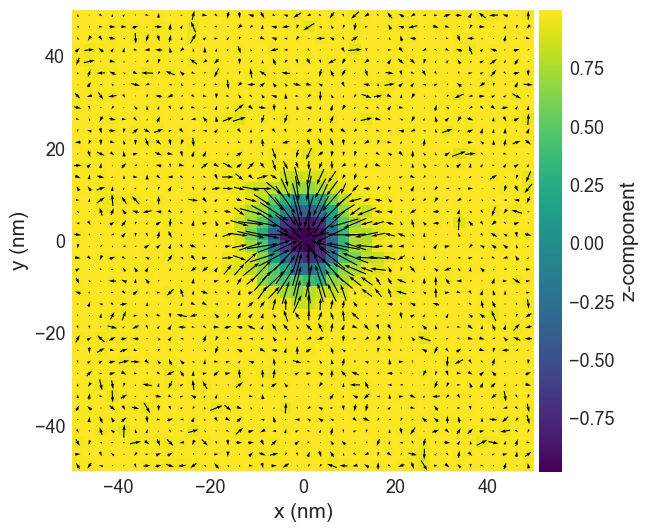

In [25]:
# save the below image as 'm0.png' in the same directory as the notebook
system.m.plane('z').mpl()

In [26]:
df.tools.topological_charge(system.m.plane('z'), method='berg-luescher')

-1.0010115254673722